In [4]:
import numpy as np 
from numba import njit
import matplotlib.pyplot as plt
import cv2

# Numba implementation


In [2]:
@njit
def ObsExp(Matrix):
    MatrixShape = Matrix.shape[0]
    Matrix_Exp = np.zeros((MatrixShape, MatrixShape))
    for i in range(MatrixShape):
        for j in range(MatrixShape):
            Diag = np.diag(Matrix, (j - i))
            Avg = np.mean(Diag)
            Matrix_Exp[i, j] = Avg
    
    return Matrix/Matrix_Exp

@njit
def PadMatrix(Matrix, Kernel):
    KernelRadius = Kernel.shape[0] // 2
    MatrixShape = Matrix.shape
    PaddedMatrix = np.ones((MatrixShape[0] + 2 * KernelRadius, 
                            MatrixShape[1] + 2 * KernelRadius))
    for i in range(MatrixShape[0]):
        for j in range(MatrixShape[1]):
            PaddedMatrix[i + KernelRadius, j + KernelRadius] = Matrix[i,j]

    return PaddedMatrix

@njit
def TakePixelArea(PaddedMatrix, x, y, Kernel):
    KernelRadius = Kernel.shape[0] // 2
    x += KernelRadius
    y += KernelRadius

    PixelArea = PaddedMatrix[ x - KernelRadius : x + KernelRadius + 1,
                              y - KernelRadius : y + KernelRadius + 1]
    
    return PixelArea


@njit
def CumputePearsonMatrix(Matrix, Kernel):
    MatrixShape = Matrix.shape
    PearsonMatrix = np.zeros(MatrixShape)
    PaddedMatrix = PadMatrix(Matrix, Kernel)

    for i in range(MatrixShape[0]):
        for j in range(MatrixShape[1]):
          PixelArea = TakePixelArea(PaddedMatrix, i, j, Kernel)
          corr = np.corrcoef(PixelArea.flatten(), Kernel.flatten())[0,1]
          PearsonMatrix[i,j] = corr

    return PearsonMatrix

@njit
def ComputeCluster(Matrix, Kernel, PearsonThreshold):
    Matrix_ObsExp = ObsExp(Matrix)
    PearsonMatrix = CumputePearsonMatrix(Matrix_ObsExp, Kernel)
    Pearson_filtered = PearsonMatrix > PearsonThreshold
    ClusterImage = (Pearson_filtered * 255).astype(np.uint8)

    return ClusterImage

def FindCenters(ClusterImage):

    Contours, Hierarchies = cv2.findContours(ClusterImage, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    X_coord = []
    Y_coord = []
    for i in Contours:
        M = cv2.moments(i)
        if M['m00'] != 0:
            x = int(M['m10']/M['m00'])
            y = int(M['m01']/M['m00'])
        X_coord.append(x)
        Y_coord.append(y)

    Coodinates = np.array([X_coord, Y_coord]).T
    Coodinates = np.unique(Coodinates, axis=0)
    MaskTriangular = Coodinates[:,0] > Coodinates[:,1]
    Coodinates = Coodinates[MaskTriangular]
    MaskDistance = np.abs(Coodinates[:,0] - Coodinates[:,1]) < 60_000 / 800 #Biological reasoning, 60_000 is genomic distance, 800 is matrix resolution
    Coodinates = Coodinates[MaskDistance]

    return Coodinates

def main(Matrix, Kernel, PearsonThreshold):
    ClusterImage = ComputeCluster(HiC_Matrix_raw, Kernel_Loop, PearsonThreshold)
    Coodinates = FindCenters(ClusterImage)

    return Coodinates

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/'Colab Notebooks'/*.csv /content

Mounted at /content/drive


In [19]:
!ls

 drive					 'HPPL Project - Matrix.800bp.688n.csv'
'HPPL Project - Matrix.800bp.1188n.csv'  'HPPL Project - Matrix.csv'
'HPPL Project - Matrix.800bp.188n.csv'	 'Kernel - Loop.csv'
'HPPL Project - Matrix.800bp.438n.csv'	 'Kernel - Small loops.csv'
'HPPL Project - Matrix.800bp.63n.csv'	  sample_data


In [88]:
HiC_Matrix_raw = np.genfromtxt("HPPL Project - Matrix.csv", delimiter=',')
Kernel_SmallLoop = np.genfromtxt("Kernel - Small loops.csv", delimiter=',')
Kernel_Loop = np.genfromtxt("Kernel - Loop.csv", delimiter=',')

# Check each function separately

Text(0.5, 0.98, 'Hi-C Matrix, shape (157, 157)')

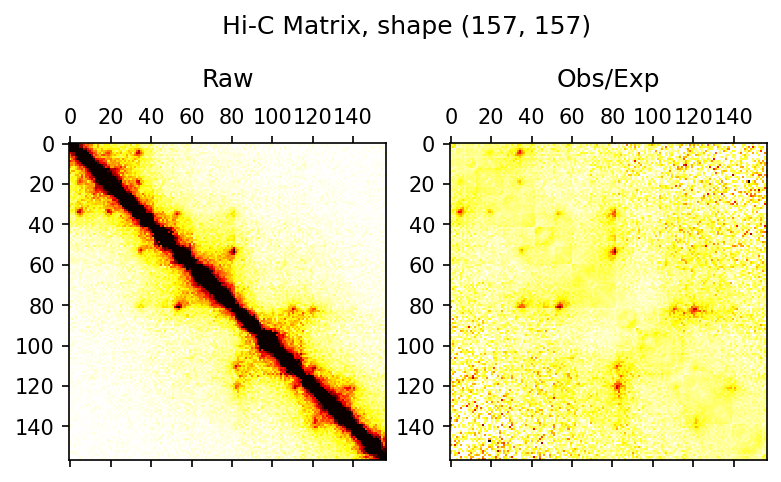

In [89]:
HiC_Matrix_ObsExp = ObsExp(HiC_Matrix_raw)

f, axs = plt.subplots(nrows = 1, ncols = 2, dpi=150)

ax = axs[0]
ax.matshow(HiC_Matrix_raw,
            cmap='hot_r',
            vmax=0.025)
ax.set_title('Raw\n')

ax = axs[1]
ax.matshow(HiC_Matrix_ObsExp,
           cmap='hot_r')
ax.set_title('Obs/Exp\n')

plt.suptitle('Hi-C Matrix, shape ' + str(HiC_Matrix_raw.shape))

Text(0.5, 0.98, 'Kernels')

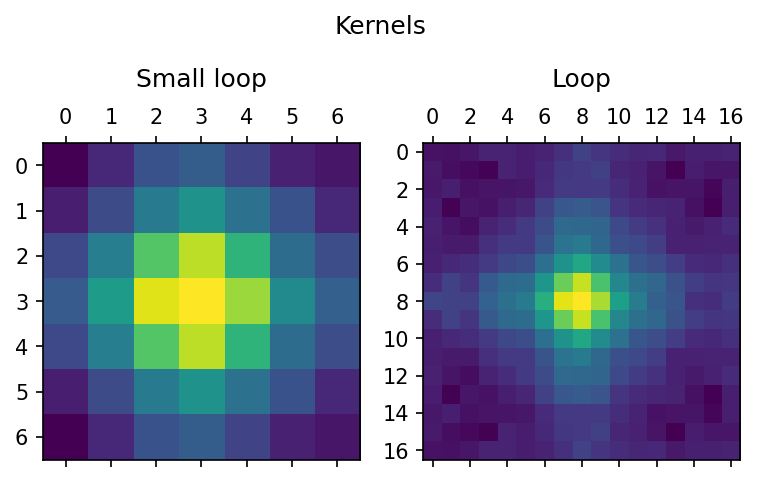

In [90]:
f, axs = plt.subplots(nrows=1, ncols=2, dpi=150)

ax = axs[0]
ax.matshow(Kernel_SmallLoop)
ax.set_title('Small loop\n')

ax = axs[1]
ax.matshow(Kernel_Loop)
ax.set_title('Loop\n')

plt.suptitle('Kernels')

In [91]:
Pearson_SmallLoop = CumputePearsonMatrix(HiC_Matrix_ObsExp, Kernel_SmallLoop)
Pearson_Loop = CumputePearsonMatrix(HiC_Matrix_ObsExp, Kernel_Loop)

Text(0.5, 0.98, 'Pearson correlation')

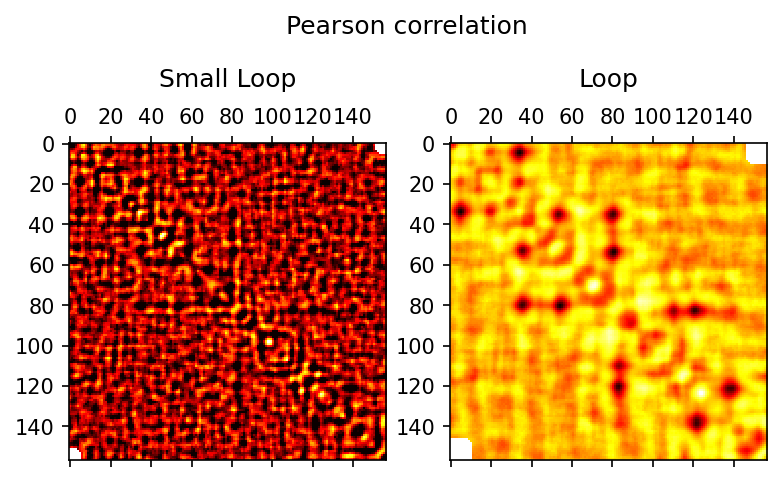

In [92]:
f, axs = plt.subplots(nrows = 1, ncols = 2, dpi=150)

ax = axs[0]
ax.matshow(Pearson_SmallLoop,
            cmap='hot_r',
            vmax=0.2)
ax.set_title('Small Loop\n')

ax = axs[1]
ax.matshow(Pearson_Loop,
           cmap='hot_r')
ax.set_title('Loop\n')

plt.suptitle('Pearson correlation')

In [93]:
PearsonThreshold = 0.3
Pearson_SmallLoop_filtered = Pearson_SmallLoop > PearsonThreshold
Pearson_Loop_filtered = Pearson_Loop > PearsonThreshold

Text(0.5, 0.98, 'Filtered clusters')

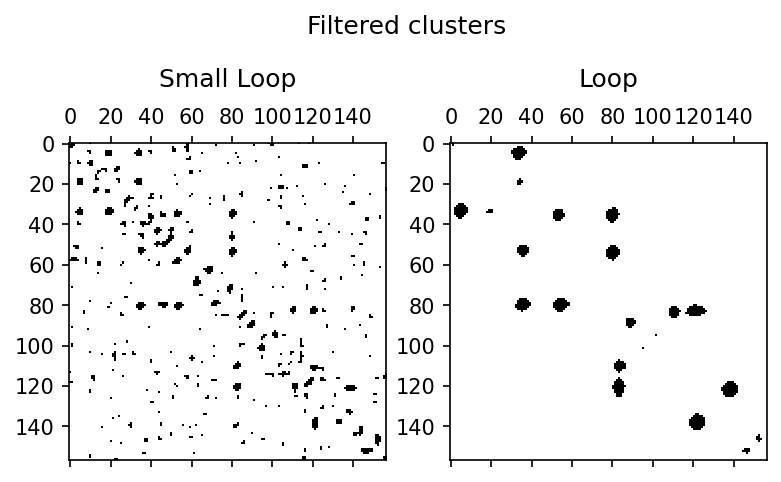

In [94]:
f, axs = plt.subplots(nrows = 1, ncols = 2, dpi=150)

ax = axs[0]
ax.matshow(Pearson_SmallLoop_filtered,
            cmap='Greys',
            vmax=0.2)
ax.set_title('Small Loop\n')

ax = axs[1]
ax.matshow(Pearson_Loop_filtered,
           cmap='Greys')
ax.set_title('Loop\n')

plt.suptitle('Filtered clusters')

In [95]:
ClusterImage = (Pearson_Loop_filtered * 255).round().astype(np.uint8)
Coodinates = FindCenters(ClusterImage)

Text(0.5, 1.05, 'Raw\n')

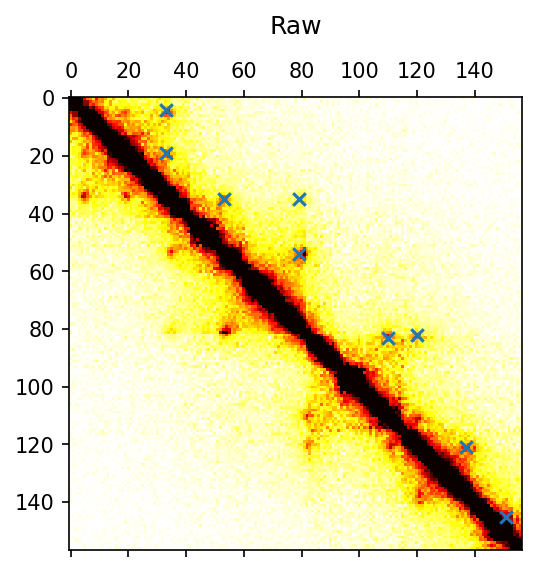

In [96]:
f, ax = plt.subplots(dpi=150)

ax.matshow(HiC_Matrix_raw,
            cmap='hot_r',
            vmax=0.025)
ax.scatter(Coodinates[:,0], Coodinates[:,1], marker = "x")
ax.set_title('Annotated patterns\n')

# Check main()

Text(0.5, 1.05, 'Raw\n')

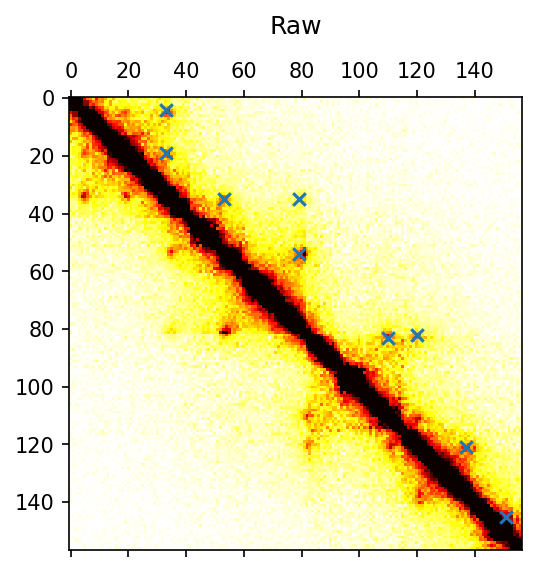

In [97]:
Coordinates = main(HiC_Matrix_raw, Kernel_Loop, 0.3)

f, ax = plt.subplots(dpi=150)

ax.matshow(HiC_Matrix_raw,
            cmap='hot_r',
            vmax=0.025)
ax.scatter(Coodinates[:,0], Coodinates[:,1], marker = "x")
ax.set_title('Annotated patterns\n')

In [98]:
ArrayN = [63, 188, 438, 688, 1188]
TimeArray_JIT = []
for N in ArrayN:
    FileName = f'HPPL Project - Matrix.800bp.{N}n.csv'
    HiC_Matrix_raw = np.genfromtxt(FileName, delimiter=',')
    HiC_Matrix_raw[np.isnan(HiC_Matrix_raw)] = 0
    TimeN = %timeit -o -r 3 main(HiC_Matrix_raw, Kernel_Loop, 0.3)
    TimeN = np.mean(TimeN.all_runs)
    TimeArray_JIT.append(TimeN)

24.6 ms ± 762 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
220 ms ± 2.13 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.32 s ± 21.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3.5 s ± 26.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
12 s ± 69.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [99]:
TimeArray_JIT

[0.24565311433343595,
 0.22021276866659414,
 1.3221447013332484,
 3.50011934733296,
 11.965205257333158]

# Naive implementation

In [100]:
def ObsExp_no_JIT(Matrix):
    MatrixShape = Matrix.shape[0]
    Matrix_Exp = np.zeros((MatrixShape, MatrixShape))
    for i in range(MatrixShape):
        for j in range(MatrixShape):
            Diag = np.diag(Matrix, (j - i))
            Avg = np.mean(Diag)
            Matrix_Exp[i, j] = Avg
    
    return Matrix/Matrix_Exp

def PadMatrix_no_JIT(Matrix, Kernel):
    KernelRadius = Kernel.shape[0] // 2
    MatrixShape = Matrix.shape
    PaddedMatrix = np.ones((MatrixShape[0] + 2 * KernelRadius, 
                            MatrixShape[1] + 2 * KernelRadius))
    for i in range(MatrixShape[0]):
        for j in range(MatrixShape[1]):
            PaddedMatrix[i + KernelRadius, j + KernelRadius] = Matrix[i,j]

    return PaddedMatrix

def TakePixelArea_no_JIT(PaddedMatrix, x, y, Kernel):
    KernelRadius = Kernel.shape[0] // 2
    x += KernelRadius
    y += KernelRadius

    PixelArea = PaddedMatrix[ x - KernelRadius : x + KernelRadius + 1,
                              y - KernelRadius : y + KernelRadius + 1]
    
    return PixelArea

def CumputePearsonMatrix_no_JIT(Matrix, Kernel):
    MatrixShape = Matrix.shape
    PearsonMatrix = np.zeros(MatrixShape)
    PaddedMatrix = PadMatrix_no_JIT(Matrix, Kernel)

    for i in range(MatrixShape[0]):
        for j in range(MatrixShape[1]):
          PixelArea = TakePixelArea_no_JIT(PaddedMatrix, i, j, Kernel)
          corr = np.corrcoef(PixelArea.flatten(), Kernel.flatten())[0,1]
          PearsonMatrix[i,j] = corr

    return PearsonMatrix

def ComputeCluster_no_JIT(Matrix, Kernel, PearsonThreshold):
    Matrix_ObsExp = ObsExp_no_JIT(Matrix)
    PearsonMatrix = CumputePearsonMatrix_no_JIT(Matrix_ObsExp, Kernel)
    Pearson_filtered = PearsonMatrix > PearsonThreshold
    ClusterImage = (Pearson_filtered * 255).astype(np.uint8)

    return ClusterImage

def FindCenters(ClusterImage):

    Contours, Hierarchies = cv2.findContours(ClusterImage, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    X_coord = []
    Y_coord = []
    for i in Contours:
        M = cv2.moments(i)
        if M['m00'] != 0:
            x = int(M['m10']/M['m00'])
            y = int(M['m01']/M['m00'])
        X_coord.append(x)
        Y_coord.append(y)

    Coodinates = np.array([X_coord, Y_coord]).T
    Coodinates = np.unique(Coodinates, axis=0)
    MaskTriangular = Coodinates[:,0] > Coodinates[:,1]
    Coodinates = Coodinates[MaskTriangular]
    MaskDistance = np.abs(Coodinates[:,0] - Coodinates[:,1]) < 60_000 / 800 #Biological reasoning, 60_000 is genomic distance, 800 is matrix resolution
    Coodinates = Coodinates[MaskDistance]

    return Coodinates

def main_no_JIT(Matrix, Kernel, PearsonThreshold):
    ClusterImage = ComputeCluster_no_JIT(HiC_Matrix_raw, Kernel_Loop, PearsonThreshold)
    Coodinates = FindCenters(ClusterImage)

    return Coodinates

In [101]:
ArrayN = [63, 188, 438, 688, 1188]
TimeArray_no_JIT = []
for N in ArrayN:
    FileName = f'HPPL Project - Matrix.800bp.{N}n.csv'
    HiC_Matrix_raw = np.genfromtxt(FileName, delimiter=',')
    HiC_Matrix_raw[np.isnan(HiC_Matrix_raw)] = 0
    TimeN = %timeit -o -r 3 main_no_JIT(HiC_Matrix_raw, Kernel_Loop, 0.3)
    TimeN = np.mean(TimeN.all_runs)
    TimeArray_no_JIT.append(TimeN)

380 ms ± 23.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<ipython-input-100-7370b47002f1>:10: RuntimeWarning: invalid value encountered in true_divide
  return Matrix/Matrix_Exp


3.34 s ± 172 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
17.9 s ± 75.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


46.5 s ± 616 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2min 15s ± 235 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [102]:
TimeArray_no_JIT

[0.3801128626667681,
 3.3375545339998403,
 17.918484662666742,
 46.50809093266677,
 135.85416073133334]

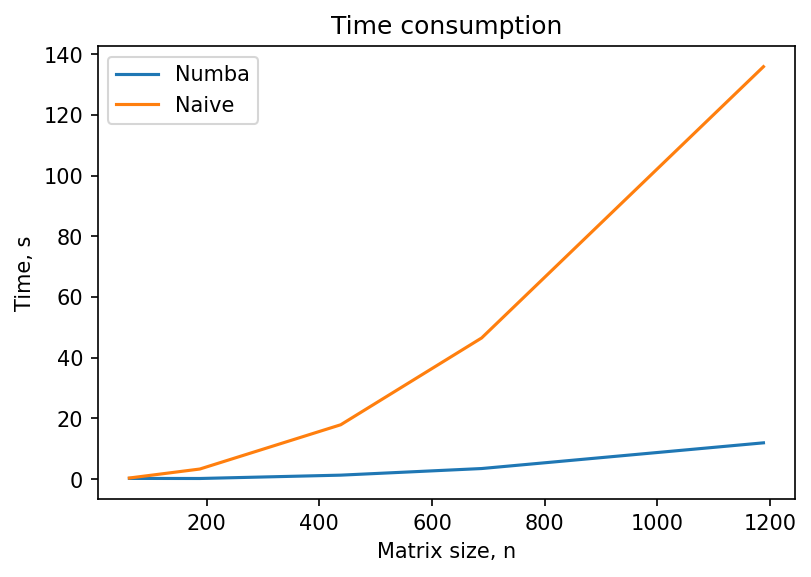

In [15]:
ArrayN = np.array([63, 188, 438, 688, 1188])

TimeArray_JIT = np.array([0.24565311433343595,
0.22021276866659414,
1.3221447013332484,
3.50011934733296,
11.965205257333158])

TimeArray_no_JIT = np.array([0.3801128626667681,
3.3375545339998403,
17.918484662666742,
46.50809093266677,
135.85416073133334])


f, ax = plt.subplots(dpi=150)

ax.plot(ArrayN, TimeArray_JIT, label='Numba')
ax.plot(ArrayN, TimeArray_no_JIT, label='Naive')

plt.title('Time consumption')
plt.xlabel('Matrix size, n')
plt.ylabel('Time, s')

plt.legend()